In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sea

torch.__version__


'1.12.1'

In [5]:
data = torch.load('../val-weights.pth')
len(data.values())

4

In [162]:
PATH = '/scratch/fk/R1/D2_0_4.pt'

weights = torch.load(PATH, map_location=torch.device('cpu'))

In [163]:
for key, value in weights.items():
    print(key, ":", value.shape)

conv1.0.weight : torch.Size([32, 1, 3, 3])
conv2.0.weight : torch.Size([32, 32, 3, 3])
conv3.0.weight : torch.Size([64, 32, 3, 3])
conv4.0.weight : torch.Size([64, 64, 3, 3])
fc.weight : torch.Size([10, 64])
fc.bias : torch.Size([10])


<AxesSubplot:ylabel='Density'>

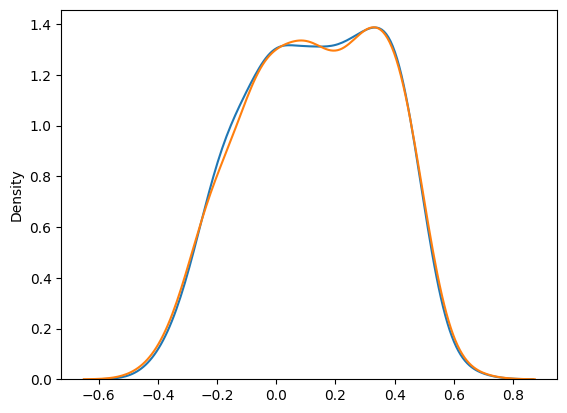

In [208]:
sea.kdeplot(weights['conv1.0.weight'].view(-1).numpy())
sea.kdeplot(weights['conv1.0.weight'].view(-1).numpy() + torch.randn(32 * 3 * 3).numpy()*0.025)

# sea.histplot(torch.randn(1000) * 0.01)


In [173]:
torch.randn(1000) * 0.01

tensor([ 1.4322e-02, -8.3251e-03, -1.2778e-02,  8.9159e-04,  3.0423e-03,
         4.2605e-03,  1.5115e-04, -6.5305e-03,  9.4144e-03,  1.2533e-02,
         8.6921e-03,  1.1397e-02, -1.2651e-03,  1.1550e-02,  2.2309e-02,
        -5.8216e-03, -4.1713e-03,  1.2374e-02,  9.0841e-03,  1.1367e-02,
        -8.6163e-03,  6.5446e-03, -5.4696e-03,  2.0450e-02,  6.3378e-03,
         4.6432e-03, -4.7448e-03, -5.9032e-03,  8.2640e-03, -1.0461e-02,
         1.3367e-02, -9.9036e-03,  3.1383e-03, -7.4651e-03,  4.3662e-03,
        -9.3073e-03, -4.1978e-03,  1.4005e-02,  8.1500e-03,  6.2157e-03,
         1.4624e-02,  1.3841e-02,  2.3141e-02, -2.1029e-03, -1.0289e-03,
        -1.2010e-02, -4.4867e-03, -1.3026e-02, -1.4993e-02, -3.8437e-03,
        -3.3834e-03,  1.1519e-04, -9.9438e-04, -7.8306e-03,  7.9558e-03,
        -1.4396e-04,  3.6890e-03, -1.0473e-02,  4.1663e-03, -1.5365e-02,
        -2.8133e-04, -8.3855e-04,  3.5154e-03, -7.4653e-03,  8.5472e-03,
         1.3125e-02, -6.9428e-03,  9.8279e-03, -1.5

In [145]:
class FastGeLU(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, x):
        pi, sqrt2 = 3.141592, 1.4142135
        coeff = 0.5 * (1 + torch.tanh((sqrt2 / pi) * (x + 0.044715 * (x ** 3))))
        return x * coeff

def get_num_params(model):
    counter = 0
    for param in model.parameters():
        counter += param.numel()
    return counter 


conv = nn.Sequential(
    nn.Conv2d(4096, 256, kernel_size=1, stride=1),
    FastGeLU(),
)

conv

Sequential(
  (0): Conv2d(4096, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): FastGeLU()
)

In [210]:
x = weights['conv1.0.weight']
x.shape

torch.Size([32, 1, 3, 3])

In [211]:
for k,v in conv.state_dict().items():
    print(k, v.numel())

0.weight 1048576
0.bias 256


In [212]:
class Encoder(nn.Module):
    def __init__(self, num_layers, in_c):
        super().__init__()
        self.num_layers = num_layers
        self.in_c = in_c
        self.convs = [self.create_conv_layer(in_c=self.in_c, out_c=1, kernel_size=1) for _ in range(self.num_layers)]
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Sequential(
            nn.Linear(self.num_layers * 3 * 3, self.num_layers * 3 * 3 // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(self.num_layers * 3 * 3 // 2, 256)
        )
        self.drop = nn.Dropout(0.2)
            
    def create_conv_layer(self, in_c, out_c, kernel_size=3):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        # bs, num_layers, in_c, 3, 3
        xs = []
        bs = x.size(0)
        for i in range(self.num_layers):
            xs.append(self.convs[i](x[:, i, :]))
            
        xs = torch.stack(xs, dim=1)
        print(xs.shape)
        xs = xs.view(bs, self.num_layers * 3 * 3) # bs, num_layers * 3 * 3
        # xs = self.drop(xs)
        print(xs.shape)
        xs = self.fc(xs) # bs, 256
        return xs

In [213]:
x2 = x.unsqueeze(0).repeat(16, 1, 1, 1, 1)
x2.shape

torch.Size([16, 32, 1, 3, 3])

In [215]:
encoder = Encoder(num_layers=32, in_c=1)
encoder(x2).shape

torch.Size([16, 32, 1, 3, 3])
torch.Size([16, 288])


torch.Size([16, 256])

In [152]:
get_num_params(encoder)

79824

In [216]:
class Decoder(nn.Module):
    def __init__(self, num_layers, out_c):
        super().__init__()
        self.num_layers = num_layers
        self.out_c = out_c
        self.convs = [self.create_conv_layer(in_c=1, out_c=self.out_c, kernel_size=1) for _ in range(self.num_layers)]
        self.convs = nn.ModuleList(self.convs)
        
        self.fc = nn.Sequential(
            nn.Linear(256, self.num_layers * 3 * 3 // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(self.num_layers * 3 * 3 // 2, self.num_layers * 3 * 3),
        )
        self.drop = nn.Dropout(0.2)
            
    def create_conv_layer(self, in_c, out_c, kernel_size=3):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=kernel_size, stride=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(out_c, out_c, kernel_size=kernel_size, stride=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        # bs, 256
        bs = x.size(0)
        x = self.fc(x) # bs, num_layers * 3 * 3
        x = x.view(bs, self.num_layers, 1, 3, 3)
        x = self.drop(x)
        
        xs = []
        for i in range(self.num_layers):
            xs.append(self.convs[i](x[:, i, :]))
        
        xs = torch.stack(xs, dim=1)
        return xs

In [217]:
encoder = Encoder(num_layers=32, in_c=1)
bot= encoder(x2)
bot.shape


torch.Size([16, 32, 1, 3, 3])
torch.Size([16, 288])


torch.Size([16, 256])

In [219]:
decoder = Decoder(num_layers=32, out_c=1)
decoder(bot).shape

torch.Size([16, 32, 1, 3, 3])

In [7]:
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Dataset1D

model = Unet1D(
    dim=512,
    dim_mults=(1, 2, 4),
    channels=1
).to('cuda')

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 512,
    timesteps = 100,
    objective = 'pred_noise'
).to('cuda')

In [11]:
x = torch.randn(4, 1, 512, device='cuda')
layer = torch.tensor([10] * 4, device='cuda')

loss = diffusion(x, layer)
loss

tensor(1.2038, device='cuda:0', grad_fn=<MeanBackward0>)

In [12]:
loss.backward()

In [6]:
model.init_conv.parameters()

<generator object Module.parameters at 0x7f0519c0f4a0>

In [10]:
torch.tensor([10] * 5).long()

tensor([10, 10, 10, 10, 10])

In [47]:
def positional_encodings(indices, max_length, embedding_dim):
    """
    Generate positional encodings for a tensor of indices.

    Args:
    - indices (torch.Tensor): Tensor of indices representing positions in the sequence.
    - max_length (int): Maximum length of the sequence.
    - embedding_dim (int): Dimension of the positional embeddings.

    Returns:
    - pos_encodings (torch.Tensor): Tensor of positional encodings for the input indices.
    """
    # Create positions tensor
    positions = torch.arange(max_length).unsqueeze(1).float()  # Shape: (max_length, 1)

    # Compute div_term
    div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim))  # Shape: (embedding_dim / 2)

    # Compute positional encodings
    pos_encodings = torch.zeros(max_length, embedding_dim)  # Shape: (max_length, embedding_dim)
    pos_encodings[:, 0::2] = torch.sin(positions * div_term)
    pos_encodings[:, 1::2] = torch.cos(positions * div_term)

    # Gather positional encodings for the input indices
    pos_encodings = pos_encodings[indices, :]  # Shape: (batch_size, embedding_dim)

    return pos_encodings

In [50]:
t = torch.randint(low=1, high=100, size=(16,))
positional_encodings(t, 100, 128).shape


torch.Size([16, 128])

In [13]:
torch.arange(0, t) # (time, 1)

TypeError: arange() received an invalid combination of arguments - got (int, Tensor), but expected one of:
 * (Number end, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Number start, Number end, Number step, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
